In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from qiskit import(
    QuantumCircuit, 
    ClassicalRegister, 
    QuantumRegister,
    transpile)

from qiskit_aer import AerSimulator


from qiskit.providers.basic_provider import BasicProvider

#backend = BasicProvider().get_backend('basic_simulator')

In [29]:
def build_op(N_s, site, op):
    Op = np.identity(1)
    for s in range(N_s):
        if s == site:
            Op = np.kron(Op, op)
        else:
            Op = np.kron(Op, np.identity(2))
    return Op

In [30]:
myfolder='noisy_figs/'

In [31]:
N_s = 3

In [32]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
sp = (x + 1j * y) / 2
sm = (x - 1j * y) / 2
had = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
n = np.array([[0, 0], [0, 1]])

X = []
Y = []
Z = []
Sp = []
Sm = []
Had = []
N = []

for s in range(N_s):
    X.append(build_op(N_s, s, x))
    Y.append(build_op(N_s, s, y))
    Z.append(build_op(N_s, s, z))
    Sp.append(build_op(N_s, s, sp))
    Sm.append(build_op(N_s, s, sm))
    Had.append(build_op(N_s, s, had))
    N.append(build_op(N_s, s, n))

In [33]:
CDAG = []
for s in range(N_s):
    cdag = Sm[s]
    for j in range(s):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

Wave packet approximations

$$ W = \frac{1}{\sqrt{N}} \sum_x \exp (-i k x)  \exp \left(-\frac{(x-x_0)^2}{\sigma^2} \right)  c_x^\dagger$$

where, 
$$c_x^\dagger = (-1)^x Z_0 Z_1 \cdots Z_{x-1} \sigma^{+}_x $$

Does this (-1)^x needed?


We use two approximations, cutoff in the terms of the wavepacket $n_{cut}$ and cutoff in the Pauli-string $p_{cut}$.

With the approximations, $|x-x_0| < n_{cut}$

$$ W \approx \frac{1}{\sqrt{N}} \sum_{|x-x_0|<n_{cut}//2} \exp (-i k x)  \exp \left(-\frac{(x-x_0)^2}{\sigma^2} \right)  \widetilde{c_x}^\dagger$$

where,
$$ \widetilde{c_x}^\dagger = Z_{x-p_{cut} } \cdots Z_{x-1} \sigma_x^{+} $$

In [34]:
vac = np.zeros(2**N_s, dtype=complex)
vac[0] = 1
r = [-1, 0, 1]
kr = 3 * np.pi / 8
kl = -kr
rm_state = np.zeros(2**N_s, dtype=complex)
lm_state = np.zeros(2**N_s, dtype=complex)
for s in range(N_s):
    rm_state += np.exp(1j * kr * s) * np.exp(-r[s]**2/2**2) * CDAG[s] @ vac
    lm_state += np.exp(1j * kl * s) * np.exp(-r[s]**2/2**2) * CDAG[s] @ vac
rm_state /= np.linalg.norm(rm_state)
lm_state /= np.linalg.norm(lm_state)


In [35]:
occs_rm = []
occs_lm = []
for s in range(N_s):
    occs_rm.append(np.inner(rm_state.conjugate(), N[s] @ rm_state))
    occs_lm.append(np.inner(lm_state.conjugate(), N[s] @ lm_state))

/Users/asad/miniconda3/envs/qiskit2/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/asad/miniconda3/envs/qiskit2/lib/python3.11/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/asad/miniconda3/envs/qiskit2/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$\\langle N_s \\rangle$')

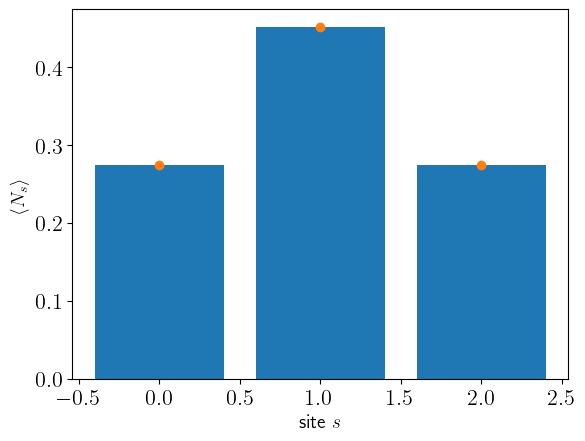

In [36]:
plt.bar(range(N_s), occs_rm)
plt.scatter(range(N_s), occs_lm)
plt.xlabel(r'site $s$')
plt.ylabel(r'$\langle N_s \rangle$')

State Prep Circuit: 
Circuit depth:  10
{'u3': 7, 'cx': 4, 'reset': 3}


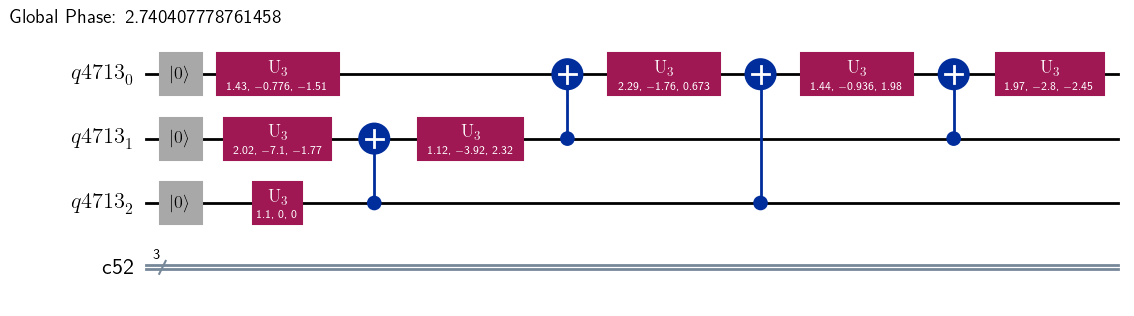

In [37]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
circ = QuantumCircuit(qreg, creg)
basis_gates = ['u1', 'u2', 'u3', 'cx']
# State-Prep
circ.initialize(rm_state, qubits=list(range(N_s)))
# for i in range(5):
#     circ = circ.decompose()
# circ.draw(output='mpl')
backend = BasicProvider().get_backend('basic_simulator')
rm_circuit = transpile(circ, backend,
                        basis_gates=basis_gates,
                        optimization_level=3)
print("State Prep Circuit: ")
print("Circuit depth: ", rm_circuit.depth())
print(dict(rm_circuit.count_ops()))
rm_circuit.draw(output='mpl')

State Prep Circuit: 
Circuit depth:  10
CX depth 4
{'u3': 7, 'cx': 4, 'reset': 3}


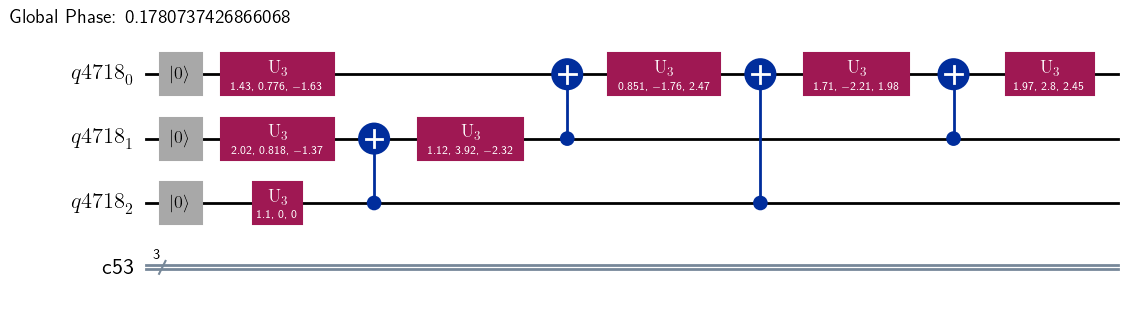

In [38]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
circ = QuantumCircuit(qreg, creg)
basis_gates = ['u1', 'u2', 'u3', 'cx']
# State-Prep
circ.initialize(lm_state, qubits=list(range(N_s)))
# for i in range(5):
#     circ = circ.decompose()
# circ.draw(output='mpl')
lm_circuit = transpile(circ, backend,
                        basis_gates=basis_gates,
                        optimization_level=3)
print("State Prep Circuit: ")
print("Circuit depth: ", lm_circuit.depth())
print("CX depth", lm_circuit.depth(filter_function=lambda op: op.operation.name == "cx") )
print(dict(lm_circuit.count_ops()))
lm_circuit.draw(output='mpl')

In [39]:
N_s = 8
N_t = 12
lam = 0.3
# hL = 0.05
dt = 1.0
N_t * dt

12.0

In [40]:
def make_circuit(t_step, num_shots, mybasis=['u1', 'u2', 'u3', 'cx'],backend = BasicProvider().get_backend('basic_simulator')):
    qreg = QuantumRegister(N_s)
    creg = ClassicalRegister(N_s)
    circ = QuantumCircuit(qreg, creg)

    # State-Prep
    # circ.initialize(init_state, qubits=list(range(N_s)))
    circ = circ.compose(rm_circuit, qubits=[0, 1, 2])
    circ = circ.compose(lm_circuit, qubits=[4, 5, 6])
    
    # Trotter Evolution
    for i in range(t_step):
        # Transverse Field
        for j in range(N_s):
            circ.rz(-2 * dt, j)
        # Nearest-neighbor
        for j in range(N_s):
            circ.rxx(-2 * lam * dt, j, (j+1) % N_s)
        # # Longitudinal Field
        # for j in range(N_s):
        #     circ.rx(-2 * hL * dt, j)
    
    # Measure
    circ.measure(qreg[::-1], creg)
    

    
    new_circuit = transpile(circ, backend,
                            basis_gates=mybasis, 
                            optimization_level=3)
    job = backend.run(new_circuit, shots = num_shots)

    result = job.result()

    counts =result.get_counts()

    return counts

In [41]:
num_shots = 8000
counts_list = []
for i in range(N_t):
    print(i)
    results = make_circuit(i, num_shots)
    counts_list.append(results)

0
1
2
3
4
5
6
7
8
9
10
11


In [42]:
qc_occ_nums = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    for key in counts_list[i]:
        for j in range(N_s):
            if key[j] == '0':
                expecz[j] += counts_list[i][key] / num_shots
            else:
                expecz[j] -= counts_list[i][key] / num_shots
    qc_occ_nums.append((1 - expecz) / 2)
qc_occ_nums = np.array(qc_occ_nums)

/Users/asad/miniconda3/envs/qiskit2/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/asad/miniconda3/envs/qiskit2/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<BarContainer object of 8 artists>

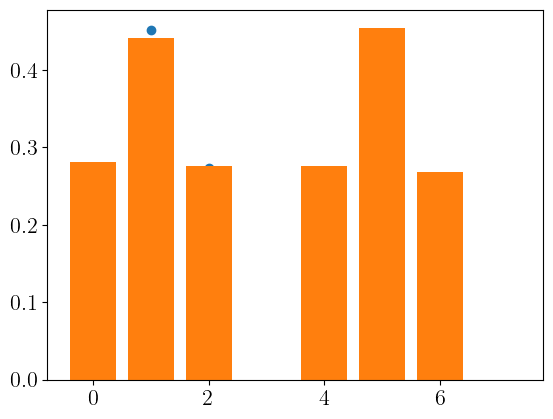

In [43]:
plt.scatter(range(3), occs_lm)
plt.bar(range(N_s), qc_occ_nums[0])

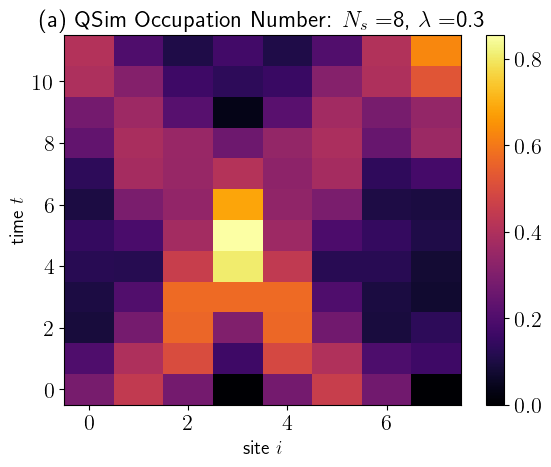

In [44]:

# Enable LaTeX in Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,        # Set default font size
    "xtick.labelsize": 16,  # X-axis tick label size
    "ytick.labelsize": 16   # Y-axis tick label size
})


x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')

plt.xlabel(r'site $i$')
plt.ylabel(r'time $t$')
title = r'(a) QSim Occupation Number: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
# title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
plt.savefig('noisy_figs/occupation2D.png')

# Add noise model

In [45]:

                                  
from qiskit_ibm_runtime import QiskitRuntimeService

#service = QiskitRuntimeService(
#    channel='ibm_quantum',
#    instance='ibm-q/open/main',
#    token="1ababa778269661553c5ddd0defcbc400047242e08208a9ee0b31a5c9a7e666ccdcd2afca9883894aa29f7c7b4ef46eeed25e1ae324544cf72d6feea0778fc55"
                 
#)
service=QiskitRuntimeService()
service.backends()


 

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_kyiv')>]

# Backend properties

Backend: ibm_kyiv
Number of Qubits: 127
Coupling Map: [[0, 1], [0, 14], [1, 2], [2, 3], [4, 3], [4, 15], [5, 4], [6, 5], [7, 6], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [13, 12], [14, 18], [16, 8], [17, 12], [17, 30], [19, 18], [20, 19], [21, 20], [21, 22], [22, 15], [22, 23], [23, 24], [24, 25], [26, 16], [26, 25], [26, 27], [28, 27], [29, 28], [29, 30], [31, 30], [31, 32], [33, 20], [33, 39], [34, 24], [35, 28], [35, 47], [36, 32], [36, 51], [37, 38], [37, 52], [39, 38], [40, 39], [40, 41], [42, 41], [42, 43], [43, 34], [44, 43], [45, 44], [45, 46], [46, 47], [48, 47], [48, 49], [50, 49], [50, 51], [53, 41], [53, 60], [54, 45], [54, 64], [55, 49], [56, 52], [57, 56], [57, 58], [58, 59], [58, 71], [59, 60], [60, 61], [61, 62], [63, 62], [63, 64], [64, 65], [66, 65], [66, 67], [67, 68], [68, 55], [68, 69], [69, 70], [70, 74], [72, 62], [72, 81], [73, 66], [73, 85], [75, 76], [75, 90], [76, 77], [77, 71], [77, 78], [79, 78], [80, 79], [80, 81], [82, 81], [82, 83], [84, 83], [85, 84

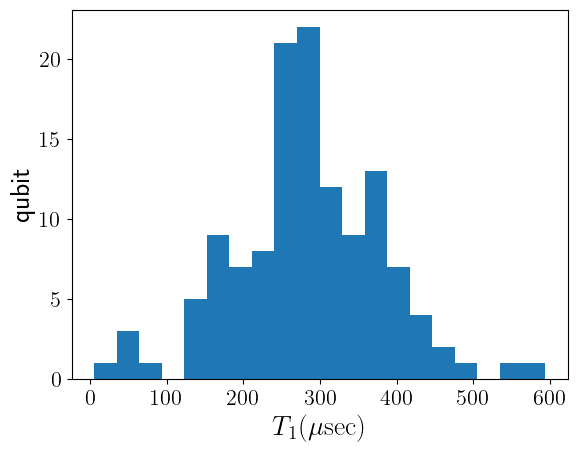

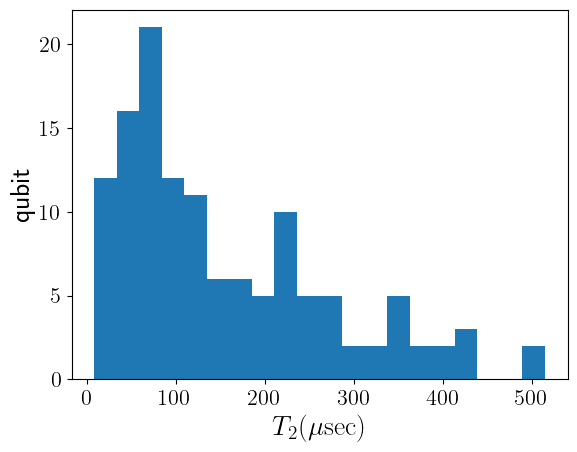

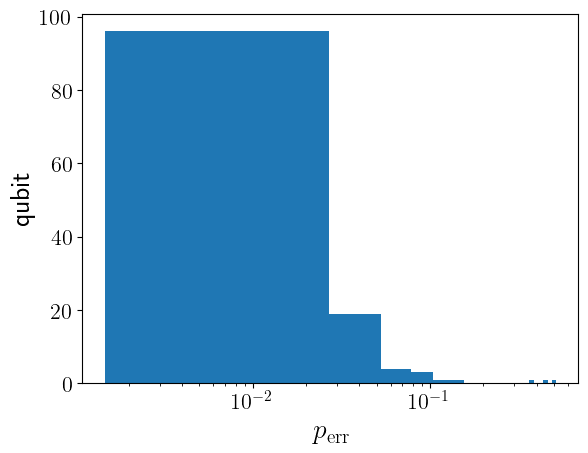

Gate: id on Qubits [0] -> Error Rate: 0.000153, Gate Time: 0.000000050 s
Gate: rz on Qubits [0] -> Error Rate: 0.000000, Gate Time: 0.000000000 s
Gate: sx on Qubits [0] -> Error Rate: 0.000153, Gate Time: 0.000000050 s
Gate: x on Qubits [0] -> Error Rate: 0.000153, Gate Time: 0.000000050 s
Gate: ecr on Qubits [0, 14] -> Error Rate: 0.006644, Gate Time: 0.000000562 s
Gate: ecr on Qubits [0, 1] -> Error Rate: 0.004829, Gate Time: 0.000000562 s
Gate: reset on Qubits [0] -> Error Rate: Not Available
Gate: reset on Qubits [0] -> Error Rate: -100000000.000000, Gate Time: 0.000001294 s


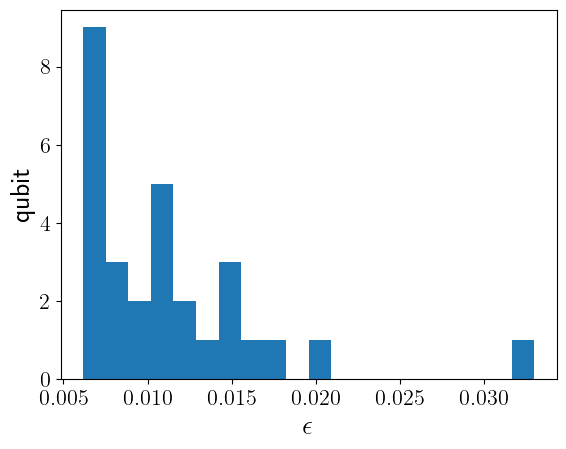

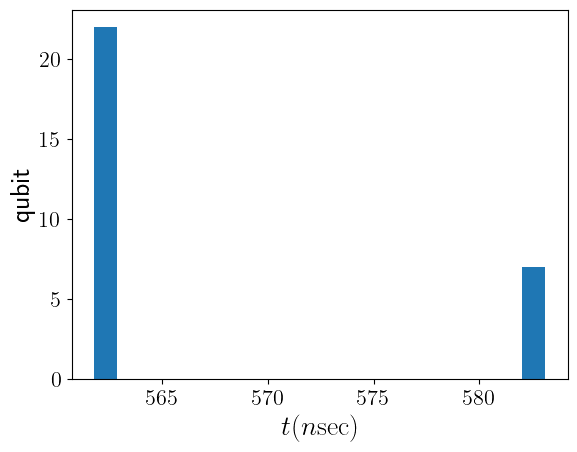

In [46]:

# get a real backend from the runtime service

backend = service.backend('ibm_kyiv')
# Or save your credentials on disk.

# Get backend properties
properties = backend.properties()

# Print general backend properties
print(f"Backend: {backend.name}")
print(f"Number of Qubits: {backend.num_qubits}")
print(f"Coupling Map: {backend.coupling_map}")

# Access specific properties
t1_list=[]
t2_list=[]
readout_list=[]
for qubit in range(backend.num_qubits):
    t1 = properties.t1(qubit)
    t1_list.append(t1)
    t2 = properties.t2(qubit)
    t2_list.append(t2)
    
    readout_error = properties.readout_error(qubit)
    readout_list.append(readout_error)
    
    #print(f"Qubit {qubit}: T1={t1*1e6:.1f} s, T2={t2*1e6:.3f} s, Readout Error={readout_error:.4f}")

_,_,fig=plt.hist(np.array(t1_list)*1e6,bins=20)
plt.xlabel(r"$T_1(\mu\mathrm{sec})$",fontsize=20)
plt.ylabel(r"qubit",fontsize=20)
plt.savefig('kyiv_T1_distribution.png',bbox_inches='tight')
plt.show()
_,_,fig=plt.hist(np.array(t2_list)*1e6,bins=20)
plt.xlabel(r"$T_2(\mu\mathrm{sec})$",fontsize=20)
plt.ylabel(r"qubit",fontsize=20)
plt.savefig('kyiv_T2_distribution.png',bbox_inches='tight')
plt.show()
_,_,fig=plt.hist(np.array(readout_list),bins=20)
plt.xlabel(r"$p_{\mathrm{err}}$",fontsize=20)
plt.ylabel(r"qubit",fontsize=20)
plt.xscale('log')
plt.savefig('kyiv_readout_error_distribution.png',bbox_inches='tight')
plt.show()


# Extract gate error rates and gate times
for gate in properties.gates:
    if 0 in gate.qubits:
        gate_name = gate.gate
        qubits = gate.qubits
        # Check if error rate is available
        try:
            error_rate = properties.gate_error(gate_name, qubits)
        except:
            error_rate=-100000000
            print(f"Gate: {gate_name} on Qubits {qubits} -> Error Rate: Not Available")
    
       
        gate_time = properties.gate_length(gate_name, qubits)
       
    
        print(f"Gate: {gate_name} on Qubits {qubits} -> Error Rate: {error_rate:.6f}, Gate Time: {gate_time:.9f} s")
# Extract gate error rates and gate times
error_rate_list=[]
gate_time_list=[]
for gate in properties.gates:
    if 'ecr' in gate.gate:
           if properties.gate_error(gate.gate, gate.qubits) >0.1:
               break
           else:
               error_rate_list.append(properties.gate_error(gate.gate, gate.qubits) )
               gate_time_list.append( properties.gate_length(gate.gate,gate.qubits) )
       
    

_,_,fig=plt.hist(np.array(error_rate_list),bins=20)
plt.xlabel(r"$\epsilon$",fontsize=20)
plt.ylabel(r"qubit",fontsize=20)
plt.savefig('kyiv_gate_error_distribution.png',bbox_inches='tight')
plt.show()
_,_,fig=plt.hist(np.array(gate_time_list)*1e9,bins=20)
plt.xlabel(r"$t(n\mathrm{sec})$",fontsize=20)
plt.ylabel(r"qubit",fontsize=20)
plt.savefig('kyiv_gate_time_distribution.png',bbox_inches='tight')
plt.show()      

In [47]:
properties.gates[0].gate


'id'

In [48]:
#QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main',
#    token="1ababa778269661553c5ddd0defcbc400047242e08208a9ee0b31a5c9a7e666ccdcd2afca9883894aa29f7c7b4ef46eeed25e1ae324544cf72d6feea0778fc55")

In [49]:

service=QiskitRuntimeService()
# generate a simulator that mimics the real quantum
# system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

mybasis_gates=backend.basis_gates

In [50]:

num_shots = 8000
counts_list = []
for i in range(N_t):
    print(i)
    results = make_circuit(i, num_shots,mybasis=backend.basis_gates,backend=backend_sim)
    counts_list.append(results)


qc_occ_nums_noisy = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    for key in counts_list[i]:
        for j in range(N_s):
            if key[j] == '0':
                expecz[j] += counts_list[i][key] / num_shots
            else:
                expecz[j] -= counts_list[i][key] / num_shots
    qc_occ_nums_noisy.append((1 - expecz) / 2)
    
qc_occ_nums_noisy = np.array(qc_occ_nums_noisy)


0
1
2
3
4
5
6
7
8
9
10
11


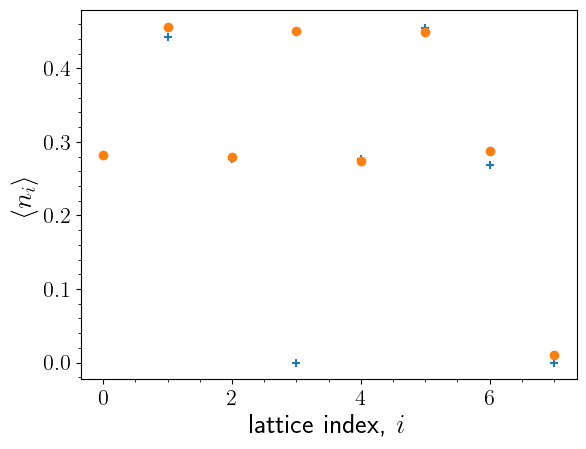

In [51]:
#plt.scatter(range(3), occs_lm,marker='x')
nstep=0
plt.scatter(range(N_s), qc_occ_nums[nstep],marker='+')
plt.scatter(range(N_s), qc_occ_nums_noisy[nstep],marker='o')
plt.minorticks_on()
plt.xlabel(r'lattice index, $i$',fontsize=20)
plt.ylabel(r'$\langle n_i \rangle$',fontsize=20)
plt.savefig(myfolder+'occupation_noisy_t%d'%nstep,bbox_inches='tight')
plt.show()


In [52]:
1/(0.45),np.sqrt(5)

(2.2222222222222223, np.float64(2.23606797749979))

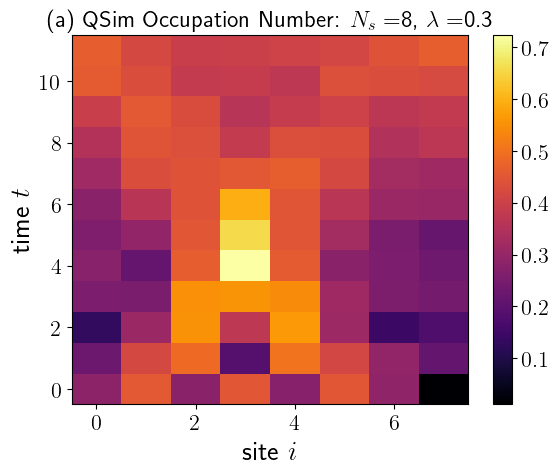

In [53]:
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums_noisy, cmap='inferno')
plt.xlabel(r'site $i$',fontsize=20)
plt.ylabel(r'time $t$',fontsize=20)
title = r'(a) QSim Occupation Number: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
# title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()
plt.savefig(myfolder+'occupation2D_kyiv_noise_model.png')

In [ ]:
ncut=3
pcut=3

df=pd.DataFrame(qc_occ_nums_noisy)
df.to_csv(myfolder+'%d_%d_%d_noisy_occupation2D',sep='\t',)